# Adaptive Agents in the Iterated Prisoner’s Dilemma: A MARL Approach with DQNs

### Import libraries

In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
tf.get_logger().setLevel('ERROR')  # suppress TensorFlow info messages
from collections import deque
from my_ipd_env import IPDEnv  # import my IPDEnv class
from dqn_agent import DQNAgent # import my DQNAgent class
import random

import warnings
# suppress warnings
warnings.filterwarnings("ignore")

### Register the defined gym environment

In [2]:
gym.envs.register(id='IPD-v0', entry_point='my_ipd_env:IPDEnv')

### Create environment function

In [3]:
# initialize the IPD environment
def create_ipd_env(max_history_length = 16, max_rounds = 24, payoff_matrix = np.array([[[3, 3], [0, 5]], [[5, 0], [1, 1]]])):
    env = gym.make("IPD-v0", max_history_length = max_history_length, max_rounds = max_rounds, payoff_matrix = payoff_matrix)
    return env

### Initialize DQN agent function

In [4]:
# initialize single DQN agent
def initialize_dqn_agent(input_shape, n_outputs):
    agent = DQNAgent(input_shape, n_outputs)
    return agent

### Plot training results function

In [5]:
def plot_training_results(episode_rewards, episode_rewards_player1, episode_rewards_player2, episode_losses_player1, episode_losses_player2):
    # plot training metrics
    plt.figure(figsize=(12, 6))
    plt.plot(episode_rewards, label='Episode Cumulative Rewards')
    plt.plot(episode_rewards_player1, label='Episode Rewards player1')
    plt.plot(episode_rewards_player2, label='Episode Rewards player2')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend()

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(episode_losses_player1, label='Episode Loss player1')
    plt.plot(episode_losses_player2, label='Episode Loss player2')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Training function

In [6]:
# train agents using input parameters
def train_agents(env, agent_player1, agent_player2, num_episodes = 30, batch_size = 16, update_target_network_freq = 5, starting_epsilon = 0.4, max_rounds = 24):
    # create lists to store training metrics
    episode_rewards = [] # cumulative
    episode_rewards_player1 = []
    episode_rewards_player2 = []
    episode_losses_player1 = []
    episode_losses_player2 = []

    # training
    for episode in range(num_episodes):
        obs, _ = env.reset()
        played_rounds = 0
        rewards_count_player1 = 0
        rewards_count_player2 = 0
        for step in range(32): # range(n): n arbitrarial until major than max_rounds
            played_rounds += 1
            epsilon = max(0.01, starting_epsilon - episode / 100)  # epsilon decay strategy starting from input parameter
            action_player1 = agent_player1.select_action(obs, epsilon)
            action_player2 = agent_player2.select_action(obs, epsilon)

            next_obs, cumulative_reward, terminated, truncated, info = env.step([action_player1, action_player2])

            done = terminated or truncated # make environment compatible with new gym versions

            # check if 'reward_player2' is present in 'final_info'
            if 'final_info' in info and 'reward_player2' in info['final_info']:
                reward_player2 = info['final_info']['reward_player2']
            else:
                # if not found in 'final_info', check in the top-level 'info'
                reward_player2 = info['reward_player2']

            rewards = [cumulative_reward - reward_player2, reward_player2]

            rewards_count_player1 += rewards[0]
            rewards_count_player2 += rewards[1]
            
            
            agent_player1.store_experience(obs, action_player1, rewards[0], next_obs, done)
            agent_player2.store_experience(obs, action_player2, rewards[1], next_obs, done)

            obs = next_obs
            if done:
                break

            if episode > 2: # start training after two complete episode
                agent_player1.train(batch_size)
                agent_player2.train(batch_size)

            if episode % update_target_network_freq == 0: # target network updates
                agent_player1.update_target_network()
                agent_player2.update_target_network()

        # record rewards and loss for this episode
        episode_rewards.append((rewards_count_player1 + rewards_count_player2)/played_rounds)
        episode_rewards_player1.append((rewards_count_player1)/played_rounds)
        episode_rewards_player2.append((rewards_count_player2)/played_rounds)

        if agent_player1.loss_history and agent_player2.loss_history:
            episode_losses_player1.append(np.mean(agent_player1.loss_history[-played_rounds:]))
            episode_losses_player2.append(np.mean(agent_player2.loss_history[-played_rounds:]))
        else:
            episode_losses_player1.append(None)
            episode_losses_player2.append(None)

    env.close()
    
    # call plotting function
    plot_training_results(episode_rewards, episode_rewards_player1, episode_rewards_player2, episode_losses_player1, episode_losses_player2)

### Print evaluation metrics function

In [7]:
def print_evaluation_metrics(evaluation_rewards, evaluation_rewards_player1, evaluation_rewards_player2, cooperative_count_player1, cooperative_count_player2, defective_count_player1, defective_count_player2, num_evaluation_episodes, combinations, played_rounds):
    # calculate and print evaluation metrics
    average_cumulative_reward = sum(evaluation_rewards) / num_evaluation_episodes
    average_player1_reward = sum(evaluation_rewards_player1) / num_evaluation_episodes
    average_player2_reward = sum(evaluation_rewards_player2) / num_evaluation_episodes
    cooperative_percentage_player1 = (cooperative_count_player1 / played_rounds) * 100
    cooperative_percentage_player2 = (cooperative_count_player2 / played_rounds) * 100
    defective_percentage_player1 = (defective_count_player1 / played_rounds) * 100
    defective_percentage_player2 = (defective_count_player2 / played_rounds) * 100

    print(f"Average Cumulative Reward: {round(average_cumulative_reward, 2)}")
    print(f"Average player1 Reward: {round(average_player1_reward, 2)}")
    print(f"Average player2 Reward: {round(average_player2_reward, 2)}")
    print(f"Cooperative Percentage player1: {round(cooperative_percentage_player1, 2)}%")
    print(f"Cooperative Percentage player2: {round(cooperative_percentage_player2, 2)}%")
    print(f"Defective Percentage player1: {round(defective_percentage_player1, 2)}%")
    print(f"Defective Percentage player2: {round(defective_percentage_player2, 2)}%")
    print("Combinations [CC, CD, DC, DD]:", combinations)

### Evaluation function

In [8]:
def evaluate_agents(env, agent_player1, agent_player2, num_evaluation_episodes = 30, max_rounds = 24):
    # initialize parameters to store evaluation metrics
    evaluation_rewards = [] # cumulative
    evaluation_rewards_player1 = []
    evaluation_rewards_player2 = []
    cooperative_count_player1 = 0
    cooperative_count_player2 = 0
    defective_count_player1 = 0
    defective_count_player2 = 0
    combinations = np.zeros(4)


    for _ in range(num_evaluation_episodes):
        obs, _ = env.reset()
        rewards_count_player1 = 0
        rewards_count_player2 = 0
        played_rounds = 0

        for _ in range(32):
            played_rounds += 1
            action_player1 = agent_player1.select_action(obs, epsilon=0)  # disable exploration for evaluation
            action_player2 = agent_player2.select_action(obs, epsilon=0)

            cooperative_count_player1 += (1-action_player1)
            cooperative_count_player2 += (1-action_player2)
            defective_count_player1 += action_player1
            defective_count_player2 += action_player2

            if action_player1 and action_player2:
                combinations[3] += 1
            elif not action_player1 and action_player2:
                combinations[2] += 1
            elif action_player1 and not action_player2:
                combinations[1] += 1
            else:
                combinations[0] += 1

            obs, cumulative_reward, terminated, truncated, info = env.step([action_player1, action_player2])
            done = terminated or truncated

            # check if 'reward_player2' is present in 'final_info'
            if 'final_info' in info and 'reward_player2' in info['final_info']:
                reward_player2 = info['final_info']['reward_player2']
            else:
                # if not found in 'final_info', check in the top-level 'info'
                reward_player2 = info['reward_player2']

            rewards = [cumulative_reward - reward_player2, reward_player2]

            rewards_count_player1 += rewards[0]
            rewards_count_player2 += rewards[1]

            if done:
                break

        # record rewards and loss for this episode
        evaluation_rewards.append((rewards_count_player1 + rewards_count_player2)/played_rounds)
        evaluation_rewards_player1.append((rewards_count_player1)/played_rounds)
        evaluation_rewards_player2.append((rewards_count_player2)/played_rounds)
    env.close()
    
    played_rounds *= num_evaluation_episodes # store in played rounds full played steps count
    
    print_evaluation_metrics(evaluation_rewards, evaluation_rewards_player1, evaluation_rewards_player2, cooperative_count_player1, cooperative_count_player2, defective_count_player1, defective_count_player2, num_evaluation_episodes, combinations, played_rounds)

### Run experiment function

In [9]:
# run experiments with input paramters
def run_experiment(max_history_length = 16, max_rounds = 24, payoff_matrix = np.array([[[3, 3], [0, 5]], [[5, 0], [1, 1]]]), num_episodes = 30, batch_size = 16, update_target_network_freq = 5, starting_epsilon = 0.4, num_evaluation_episodes = 30):
    # create environment
    env = create_ipd_env(max_history_length, max_rounds, payoff_matrix)
    
    # get input_shape and n_outputs from env
    input_shape = env.observation_space.shape
    n_outputs = env.action_space.n
    
    # initialize agents
    agent_player1 = initialize_dqn_agent(input_shape, n_outputs)
    agent_player2 = initialize_dqn_agent(input_shape, n_outputs)
    
    # train agents (automatically plot training results)
    train_agents(env, agent_player1, agent_player2, num_episodes, batch_size, update_target_network_freq, starting_epsilon, max_rounds)
    
    # evaluate agents
    evaluate_agents(env, agent_player1, agent_player2, num_evaluation_episodes, max_rounds)

## Experiment in standard conditions

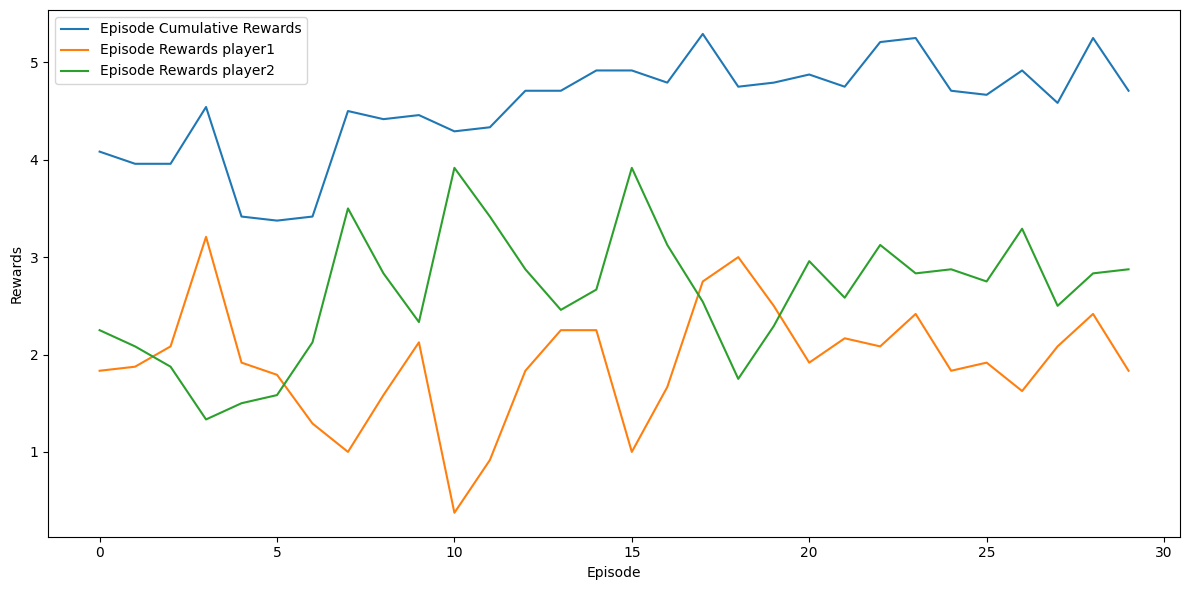

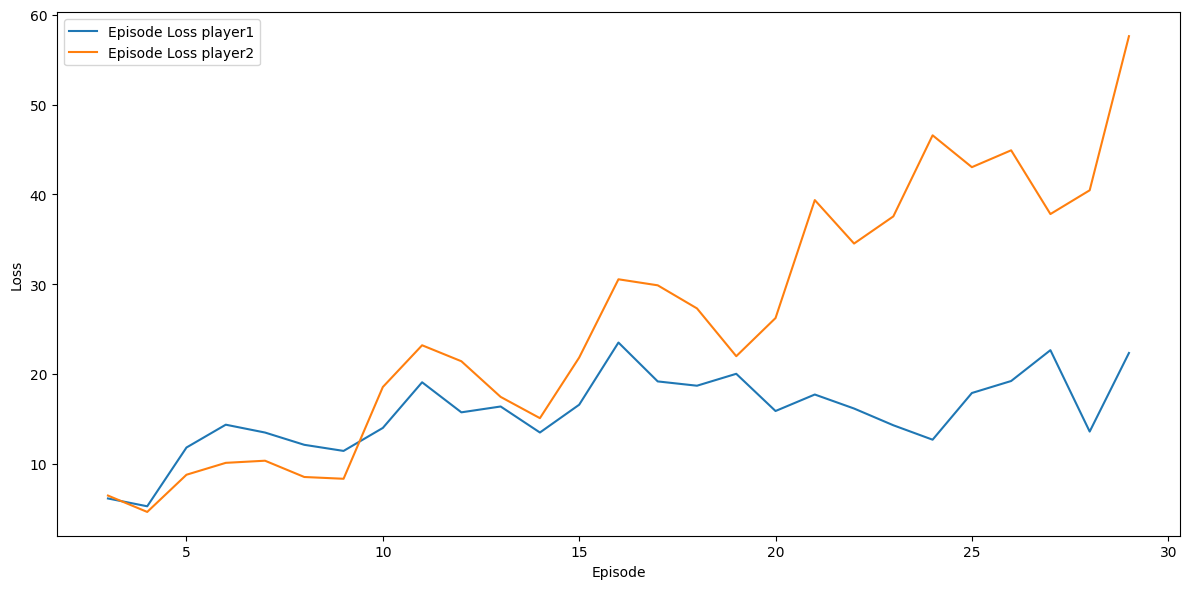

Average Cumulative Reward: 4.25
Average player1 Reward: 1.92
Average player2 Reward: 2.33
Cooperative Percentage player1: 45.83%
Cooperative Percentage player2: 37.5%
Defective Percentage player1: 54.17%
Defective Percentage player2: 62.5%
Combinations [CC, CD, DC, DD]: [ 90. 180. 240. 210.]


In [10]:
run_experiment()

## Experiment with higher payoff for both cooperating

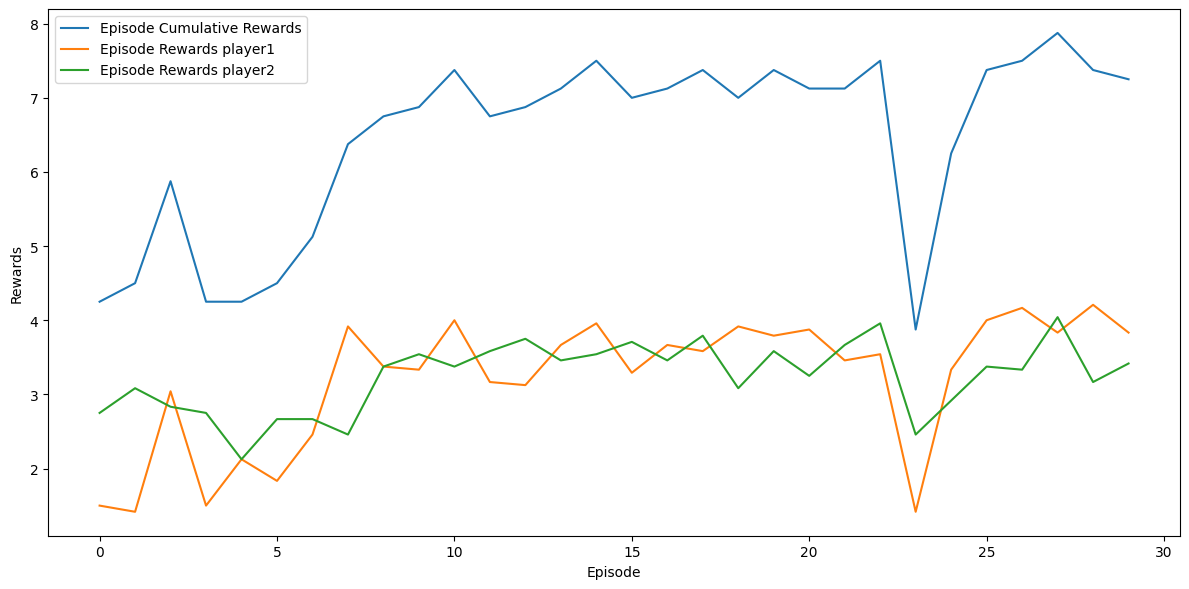

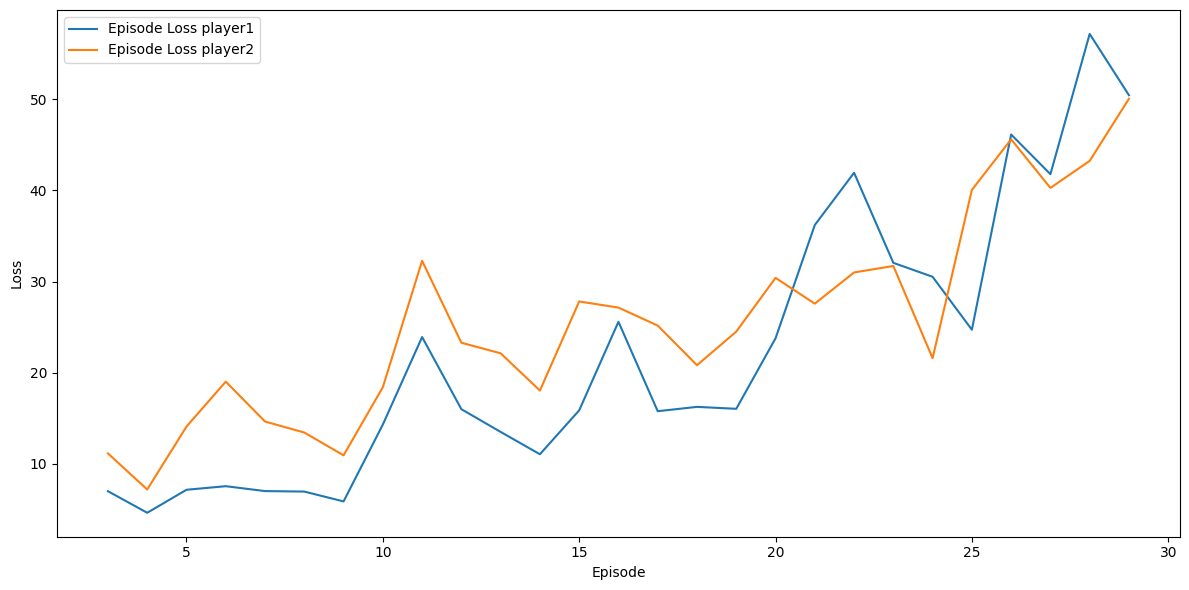

Average Cumulative Reward: 8.0
Average player1 Reward: 4.0
Average player2 Reward: 4.0
Cooperative Percentage player1: 100.0%
Cooperative Percentage player2: 100.0%
Defective Percentage player1: 0.0%
Defective Percentage player2: 0.0%
Combinations [CC, CD, DC, DD]: [720.   0.   0.   0.]


In [11]:
modified_payoff_matrix = np.array([[[4, 4], [0, 5]], [[5, 0], [1, 1]]])
run_experiment(payoff_matrix = modified_payoff_matrix)

## Experiment with lower payoff for both cooperating and higher for defecting over a cooperative partner

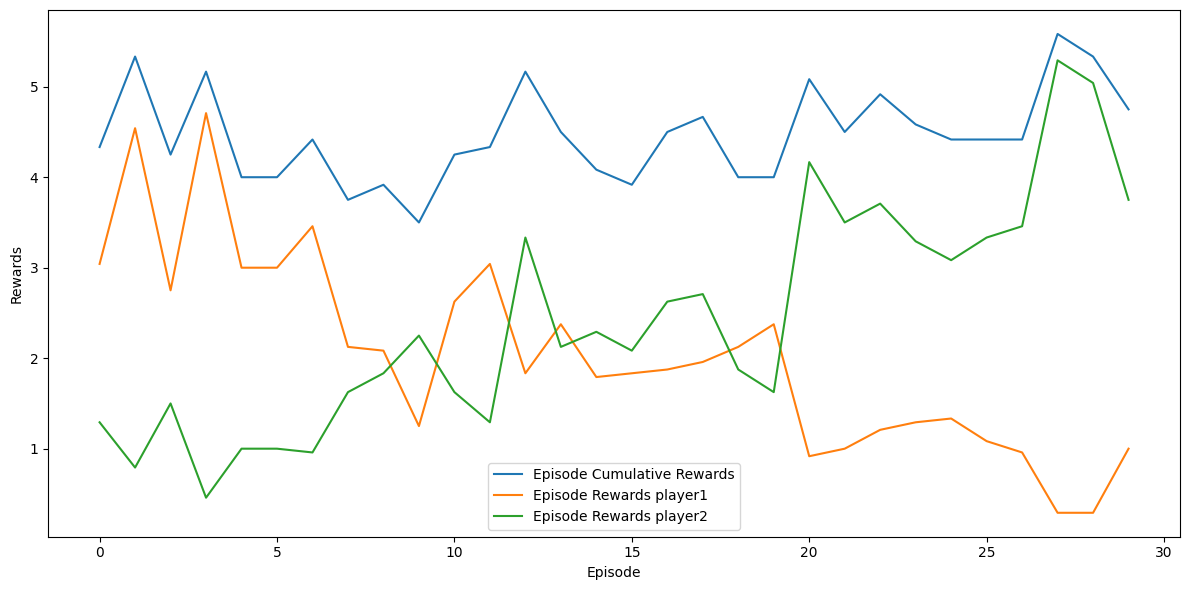

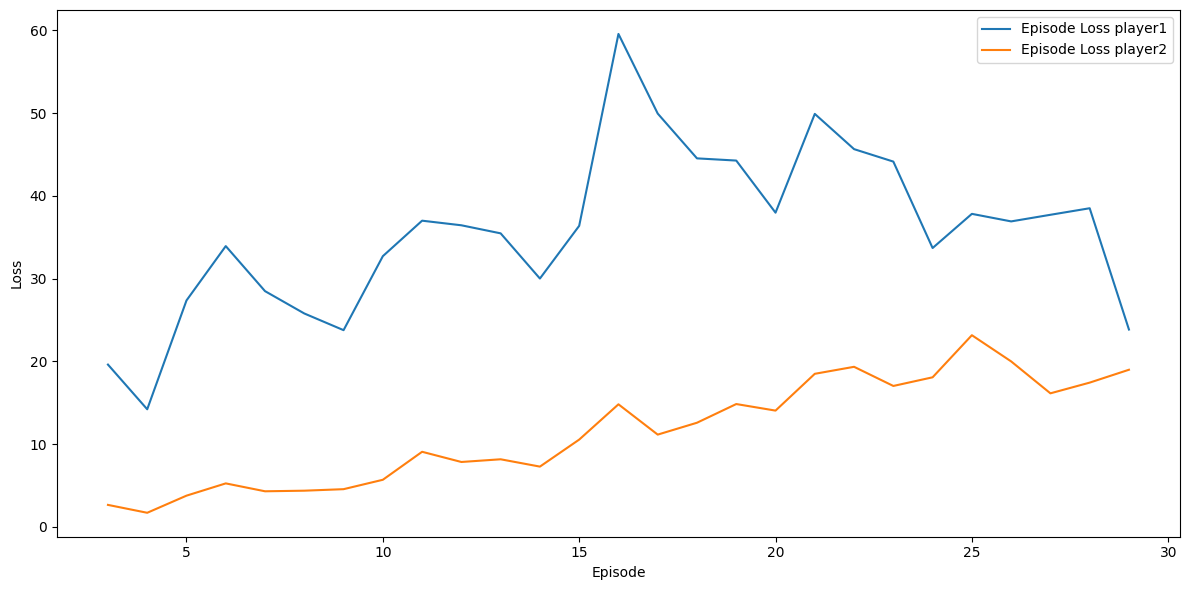

Average Cumulative Reward: 5.83
Average player1 Reward: 0.04
Average player2 Reward: 5.79
Cooperative Percentage player1: 95.83%
Cooperative Percentage player2: 0.0%
Defective Percentage player1: 4.17%
Defective Percentage player2: 100.0%
Combinations [CC, CD, DC, DD]: [  0.   0. 690.  30.]


In [20]:
modified_payoff_matrix = np.array([[[2, 2], [0, 6]], [[6, 0], [1, 1]]])
run_experiment(payoff_matrix = modified_payoff_matrix)

## Experiment with higher max_rounds
May lead agents to consider more long-term consequences

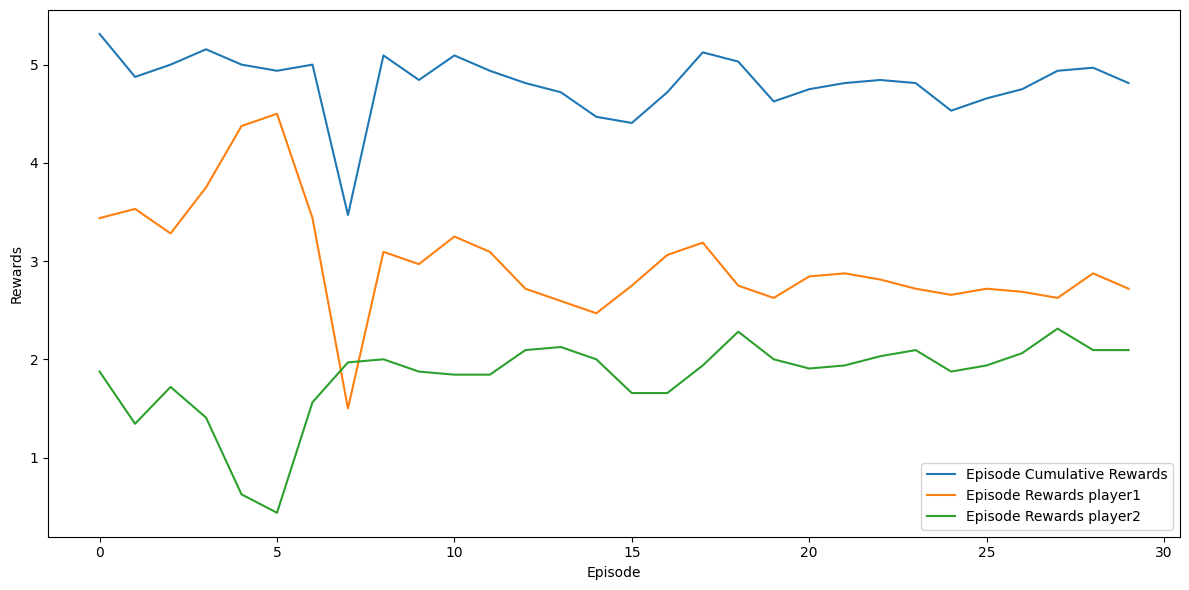

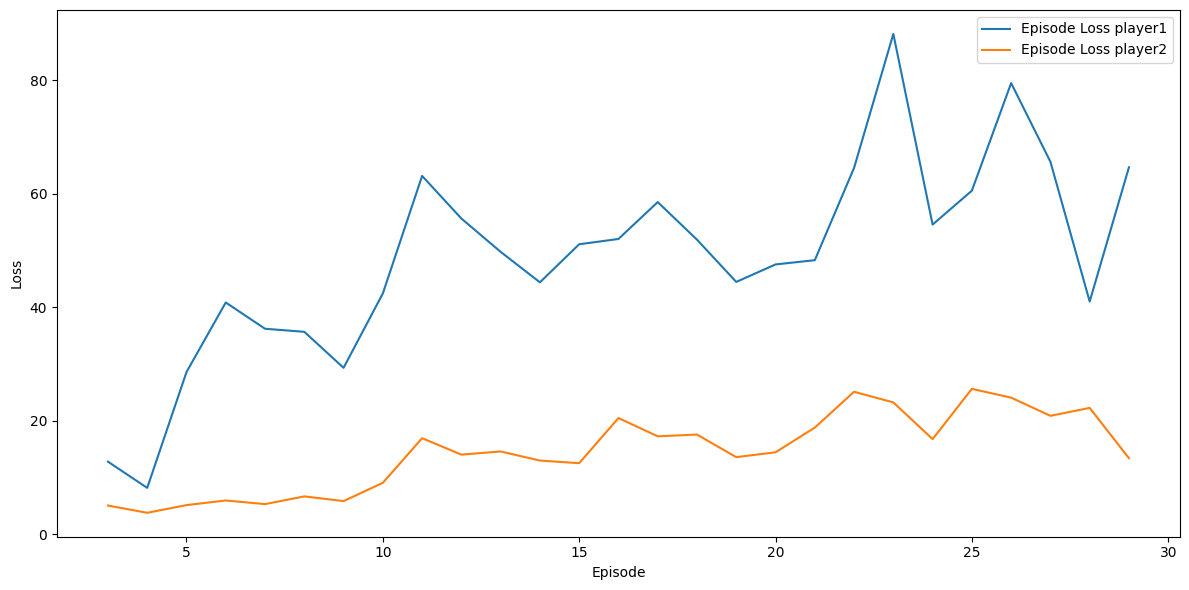

Average Cumulative Reward: 4.88
Average player1 Reward: 2.91
Average player2 Reward: 1.97
Cooperative Percentage player1: 46.88%
Cooperative Percentage player2: 65.62%
Defective Percentage player1: 53.12%
Defective Percentage player2: 34.38%
Combinations [CC, CD, DC, DD]: [240. 390. 210. 120.]


In [13]:
run_experiment(max_rounds = 32)

## Experiment with lower starting epsilon value (less exploration)

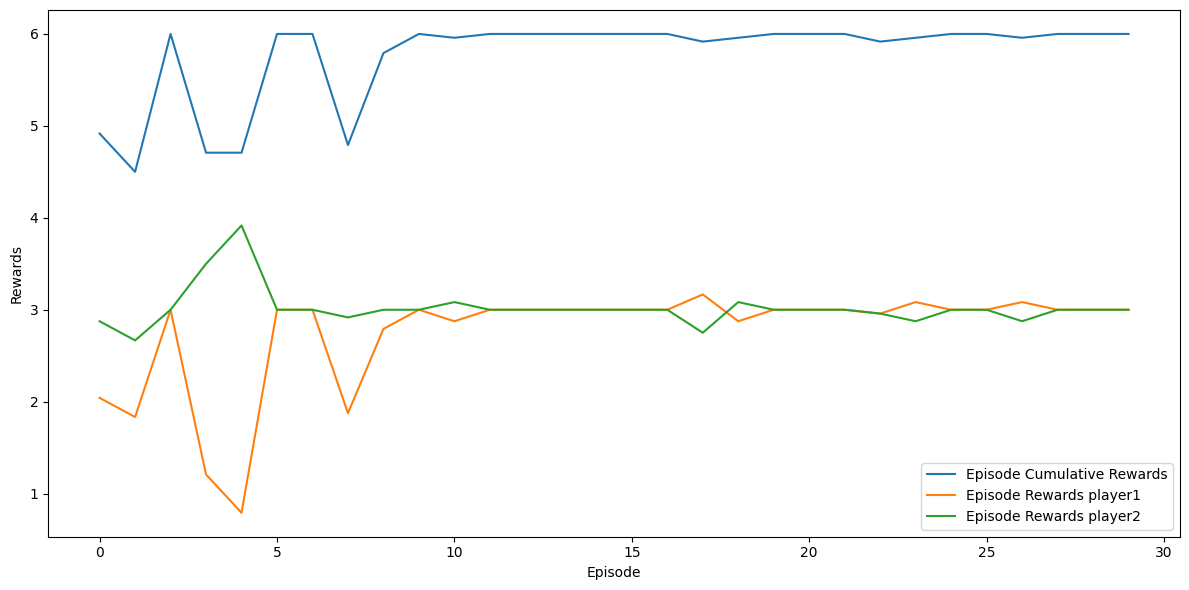

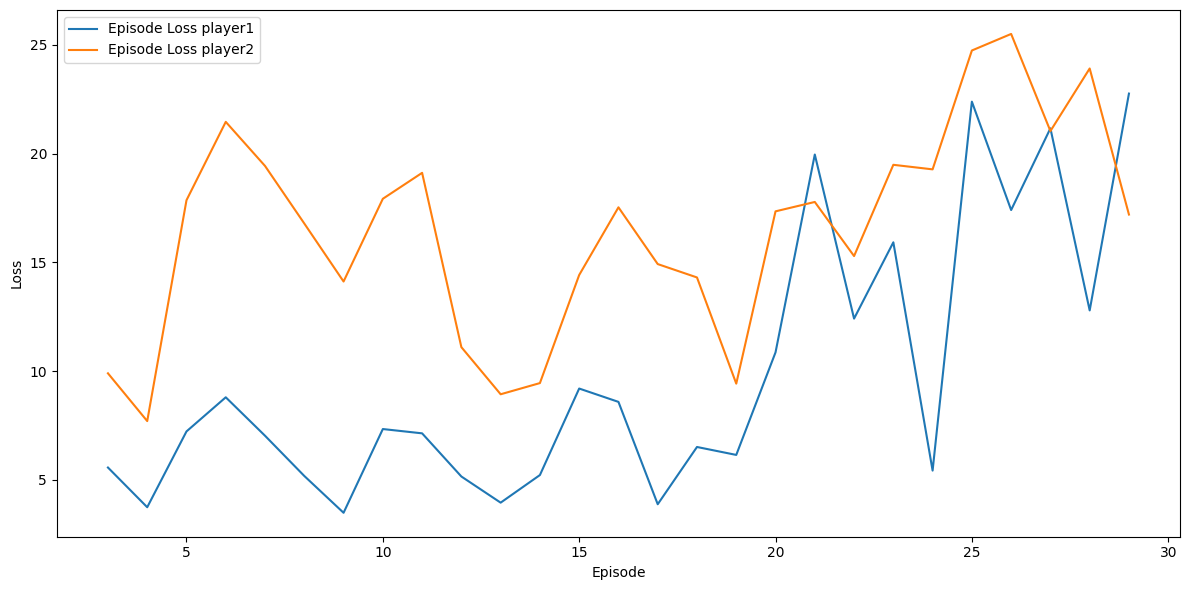

Average Cumulative Reward: 6.0
Average player1 Reward: 3.0
Average player2 Reward: 3.0
Cooperative Percentage player1: 100.0%
Cooperative Percentage player2: 100.0%
Defective Percentage player1: 0.0%
Defective Percentage player2: 0.0%
Combinations [CC, CD, DC, DD]: [720.   0.   0.   0.]


In [14]:
run_experiment(starting_epsilon = 0.1)

## Experiment with higher starting epsilon value (more exploration)

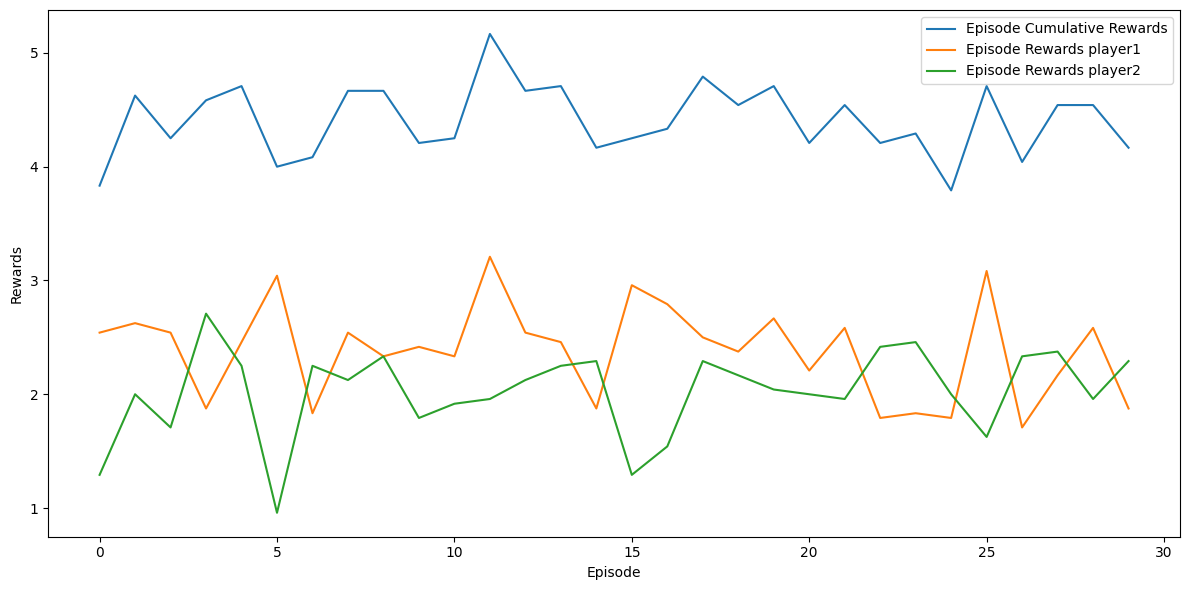

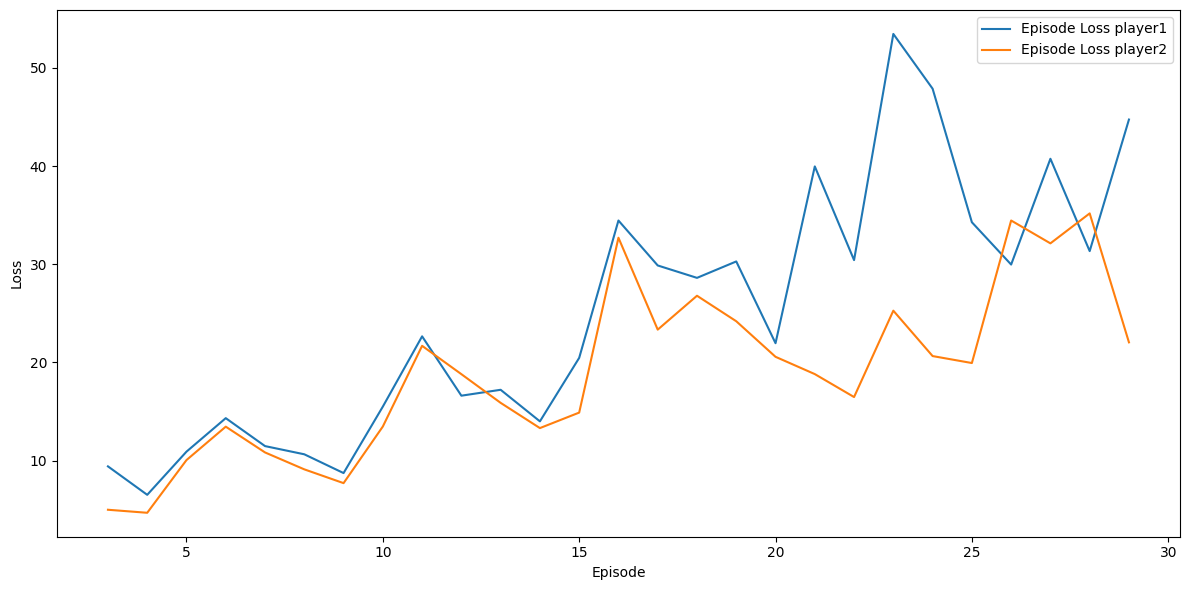

Average Cumulative Reward: 5.29
Average player1 Reward: 4.0
Average player2 Reward: 1.29
Cooperative Percentage player1: 41.67%
Cooperative Percentage player2: 95.83%
Defective Percentage player1: 58.33%
Defective Percentage player2: 4.17%
Combinations [CC, CD, DC, DD]: [300. 390.   0.  30.]


In [15]:
run_experiment(starting_epsilon = 0.8)

## Experiment with higher history lenght (more knowledge about the past)

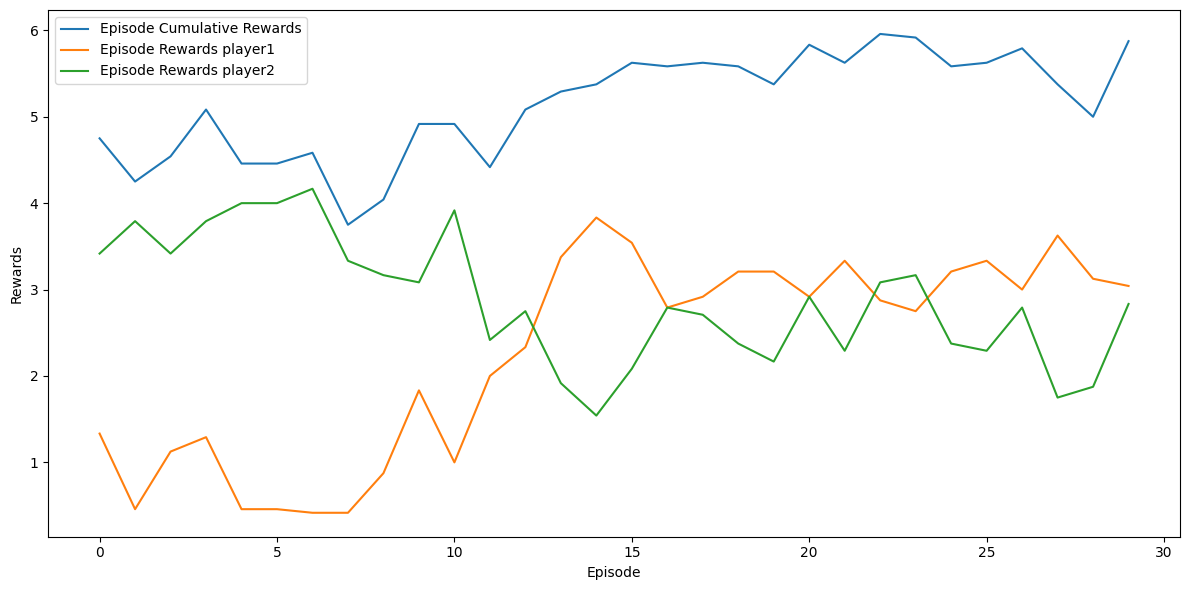

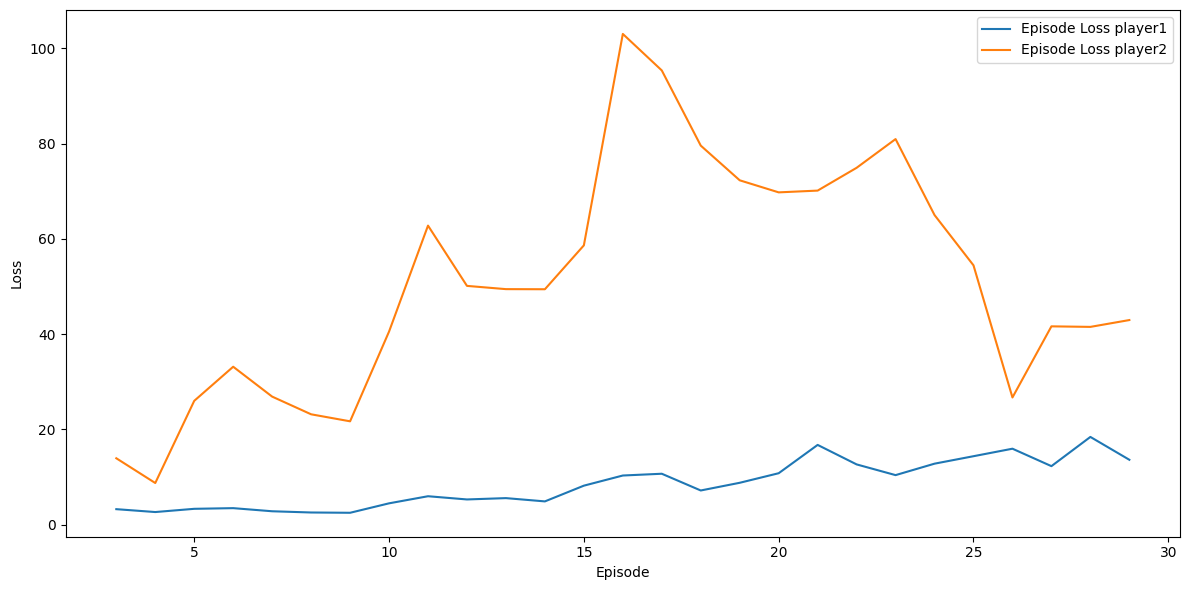

Average Cumulative Reward: 6.0
Average player1 Reward: 3.0
Average player2 Reward: 3.0
Cooperative Percentage player1: 100.0%
Cooperative Percentage player2: 100.0%
Defective Percentage player1: 0.0%
Defective Percentage player2: 0.0%
Combinations [CC, CD, DC, DD]: [720.   0.   0.   0.]


In [16]:
run_experiment(max_history_length = 24)